# Anonymization of Company Names from Earnings Call Trascripts

This is a demo of **Named Entity Swapping** proposed in the paper:

Greve, J., & Sablica, L. (2025). Named Entity Swapping for Metadata Anonymization in a Text Corpus. *arXiv preprint arXiv:2505.21128.*

# Preprocessing



Let's start with the preprocessing. Functions to import are in the file **earningsCallPreprocessing.py**.

In [1]:
# import relevant packages
import numpy as np
import pandas as pd

import os # for file reading
import glob # for the same purpose
import re # lots of regex stuff for preprocessing
import datetime # for extracting calls from specific quarter
# for reading Pdf and error handling
from pypdf import PdfReader,PdfWriter
from pypdf.errors import PdfStreamError

# func programming stuff
from toolz import curry, pipe


The total number of earnings calls for each sector aggregated across quarters and companies in our dataset is given as follows:

In [2]:
ticker_df = pd.read_csv('ticker_naics_SP500_per_year.csv').merge(pd.read_csv('Comprehensive_Tickers_with_NAIC_Industry_Labels.csv'),
                                                                left_on = 'ticker', right_on = 'Ticker')
ticker_df['Industry'].value_counts()

Industry
Manufacturing                                                               3375
Finance and Insurance                                                       1250
Utilities                                                                    624
Information                                                                  592
Retail Trade                                                                 413
Mining, Quarrying, and Oil and Gas Extraction                                369
Real Estate and Rental and Leasing                                           368
Transportation and Warehousing                                               346
Professional, Scientific, and Technical Services                             211
Accommodation and Food Services                                              196
Wholesale Trade                                                              187
Administrative and Support and Waste Management and Remediation Services     166
Health Care and Soc

We try anonymizing earnings call transcripts in the *Retail Trade* sector. The quarter we pick is Q1, 2016 (for no particular reason).

In [3]:
files = os.path.join(os.getcwd(),'SP500')
year = 2016
qrt = 1
industryname = 'Information'

In [4]:
@curry
def map_func(func, iterable):
    return map(func, iterable)

@curry
def filter_func(func, iterable):
    return filter(func, iterable)

@curry
def dateMatched(qrt, year, filepath):
    try:
        date = re.search(r'Call,\s(.*)\.pdf',filepath).group(1)
        date_dtobj = datetime.datetime.strptime(date,'%b %d, %Y')
        q_date = pd.Timestamp(date_dtobj).quarter
        y_date = pd.Timestamp(date_dtobj).year
        if q_date == qrt and y_date == year:
            return filepath
        else:
            None
    except TypeError:
        None


@curry
def industryMathced(industryname, ticker_df, filepath):
    try:
        reader = PdfReader(filepath)
        firstpage = reader.pages[0].extract_text()
        try:
            ticker = re.search(r'(NYSE|NasdaqGS|XTRA|BATS|ASX|NasdaqGM|TSX):([A-Z\.]+)', firstpage).group(2)
            try: 
                if ticker_df[ticker_df.ticker == ticker].iloc[0].Industry == industryname:           
                    return filepath
            except IndexError:
                None
        except AttributeError:
            None
    except (PdfStreamError, AttributeError) as e:
        None

In [5]:
%%capture
hoge = lambda x: industryMathced(industryname, ticker_df)(dateMatched(qrt, year)(x))

matched_filepaths = pipe(glob.glob(os.path.join(files,'**/*.pdf'), recursive = True),
                map_func(hoge),
                filter_func(lambda x: x is not None),
                list)

In [6]:
matched_filepaths

['/home/wucloud/Documents/Anonymized-RAG/SP500/2016/Transcript Digest 25/ATT, Inc., Q4 2015 Earnings Call, Jan 26, 2016.pdf',
 '/home/wucloud/Documents/Anonymized-RAG/SP500/2016/Transcript Digest 46/Adobe Systems Incorporated, Q1 2016 Earnings Call, Mar 17, 2016.pdf',
 '/home/wucloud/Documents/Anonymized-RAG/SP500/2016/Transcript Digest 37/Roper Technologies, Inc., Q4 2015 Earnings Call, Feb 01, 2016.pdf',
 '/home/wucloud/Documents/Anonymized-RAG/SP500/2016/Transcript Digest 13/Automatic Data Processing, Inc., Q2 2016 Earnings Call, Feb 03, 2016.pdf',
 '/home/wucloud/Documents/Anonymized-RAG/SP500/2016/Transcript Digest 10/T-Mobile US, Inc., Q4 2015 Earnings Call, Feb 17, 2016.pdf',
 '/home/wucloud/Documents/Anonymized-RAG/SP500/2016/Transcript Digest 10/Synopsys Inc., Q1 2016 Earnings Call, Feb 17, 2016.pdf',
 '/home/wucloud/Documents/Anonymized-RAG/SP500/2016/Transcript Digest 9/HCP, Inc., Q4 2015 Earnings Call, Feb 09, 2016.pdf',
 '/home/wucloud/Documents/Anonymized-RAG/SP500/2016/T

Now we carry out the preprocessing via the function **WriteNewPdf** in a separate python file called **earningsCallPreprocessing.py**

This operation may take time for some cases (not this example tho), so we do thread pooling.

In [7]:
from earningsCallPreprocessing import WriteNewPdf
from multiprocessing.dummy import Pool
from functools import partial

In [8]:
foldername = 'tmp_earningscall'

In [9]:
%%capture
with Pool() as pool:
    pool.map(partial(WriteNewPdf, folder = foldername), matched_filepaths)

The file name of each pdf file is converted "Company IDX.pdf" and we keep the original name in a separate dictionary filedic. This is because later, we will pass pdf files (turned into chunks of texts) and their metadata vector (including file names) to [vector stores](https://docs.llamaindex.ai/en/stable/module_guides/storing/vector_stores/).

In [10]:
filedic = {}
for idx,fname in enumerate(os.listdir(foldername)):
    filedic.update({str(fname):filedic.get(str(fname),'Company'+str(idx))})
for fname in os.listdir(foldername):
    os.rename(foldername+'/'+fname,foldername+'/'+filedic[fname]+'.pdf')


In [11]:
filedic

{'FTNT.pdf': 'Company0',
 'INTU.pdf': 'Company1',
 'DIS.pdf': 'Company2',
 'IBM.pdf': 'Company3',
 'CRM.pdf': 'Company4',
 'TTWO.pdf': 'Company5',
 'NWSA.pdf': 'Company6',
 'FDS.pdf': 'Company7',
 'NOW.pdf': 'Company8',
 'ATVI.pdf': 'Company9',
 'FIS.pdf': 'Company10',
 'TMUS.pdf': 'Company11',
 'ADBE.pdf': 'Company12',
 'VZ.pdf': 'Company13',
 'ROP.pdf': 'Company14',
 'EA.pdf': 'Company15',
 'ANSS.pdf': 'Company16',
 'PAYC.pdf': 'Company17',
 'PTC.pdf': 'Company18',
 'CHTR.pdf': 'Company19',
 'AKAM.pdf': 'Company20',
 'CDNS.pdf': 'Company21',
 'SNPS.pdf': 'Company22',
 'ORCL.pdf': 'Company23',
 'CSGP.pdf': 'Company24',
 'ADP.pdf': 'Company25',
 'ETSY.pdf': 'Company26',
 'VRSN.pdf': 'Company27',
 'ADSK.pdf': 'Company28',
 'HCP.pdf': 'Company29',
 'PANW.pdf': 'Company30',
 'T.pdf': 'Company31',
 'MSFT.pdf': 'Company32',
 'NFLX.pdf': 'Company33'}

The next step is to carry out chunking. Here we use the semantic chunker (which requires a text embedding) from LLamaIndex for this task.

In [12]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.node_parser import SemanticSplitterNodeParser

First, we must specify some settings to carry out the semantic chunking. Important settings that may have an effect on the overall anonymization outcomes are:
* breakpoint threshold (0-100): the greater, the more dissimilar the two consequtive texts need to be to be split, resulting in bigger chunks.
* text embeddings: for this demo, we use [Insutructor embeddings](https://instructor-embedding.github.io/) which generates domain-specific embeddings based on the instruction (details covered later).
* metadata function: we need to ensure that vectorstore does not have unwanted metadata from the pdf file. Metadata function is given in **earningsCallPreprocessing.py** file as function **getMeta**

First, we specify the breakpoint threshold and also obtain the metadata function from the aforementioned .py file. In addition, we define the variable instruction which is the instructor given to the Instuctor embedding.

In [13]:
from earningsCallPreprocessing import getMeta
break_thrsh = 75 # breakpoint threshold
instruction = "Represent earnings call trascripts for sentiment analysis"

Next, we construct a wrapper class so that instructor embedding can be inserted into the **SemanticSplitterNodeParser** function from the LlamaIndex.

In [14]:
from typing import List
from llama_index.core.base.embeddings.base import BaseEmbedding
from pydantic import PrivateAttr
from sentence_transformers import SentenceTransformer

class InstructorEmbedding(BaseEmbedding):
    _model: SentenceTransformer = PrivateAttr()
    _instruction: str = PrivateAttr()
    def __init__(self, model_name: str = "hkunlp/instructor-large", instruction: str = instruction):
        super().__init__()
        self._model = SentenceTransformer(model_name)
        self._instruction = instruction  
    def _get_instruction_input(self, text: str) -> List[str]:
        return [self._instruction, text]
    def embed(self, text: str) -> List[float]:
        return self._model.encode([self._get_instruction_input(text)])[0].tolist()
    def embed_query(self, text: str) -> List[float]:
        return self._model.encode([["Represent the query for retrieval:", text]])[0].tolist()
    def _aget_query_embedding(self, texts: List[str]) -> List[List[float]]:
        return self._model.encode([["Represent the query for retrieval:", t] for t in texts])
    def _get_query_embedding(self, texts: List[str]) -> List[List[float]]:
        return self._model.encode([["Represent the query for retrieval:", t] for t in texts])
    def _get_text_embedding(self, text: List[str]) -> List[float]:
    # only this function and __init__ matters, others are for not getting errors
             return self._model.encode([self._get_instruction_input(text)])[0].tolist()

Once the wrapper class is given, it can be passed to **SemanticSplitterNodeParser** for chunking.

In [15]:
embed_model = InstructorEmbedding()
documents = SimpleDirectoryReader(foldername,raise_on_error=True
                                  ,file_metadata= getMeta).load_data(num_workers=12)
splitter = SemanticSplitterNodeParser(
buffer_size=1, breakpoint_percentile_threshold=break_thrsh, embed_model=embed_model
)
#SentenceSplitter(chunk_size=126, chunk_overlap=20)
index = VectorStoreIndex.from_documents(documents,
                                        transformations=[splitter],
                                        embed_model=embed_model,
                                        show_progress = False)  

Now, the vector store contains chunked earnings call transcripts with almost no metadata (only the filename, which are in the format "Company #.pdf" are given as metadata) and the corresopnding embedding vector generated from the Instructor embedding. 

Next step is to cluster these chunks based on loading on their embedding vectors.

# Clustering of Text Chunks on the Embedding Space

We carry out clustering of text chunks based on their embedding vectors. As embedding vectors are norm one, they can be considered a point on a sphere. Hence, we carry out clustering on spheres using **spheroids** package.

In [16]:
from spheroids import SphericalClustering
import torch # matrices supplied to SphericalClustering model should be pytorch tensors

From the embedding vectors in vector store, we construct the pytorch tensor which will be passed to the **SphericalClusering** for clustering.

In [19]:
# hyperparameter settings
num_cluster = 20
min_weight = 1e-3
num_epochs = 300
tol = 1e-5

In [20]:
embdgs = [[key, index.docstore.docs.get(key).metadata['file_name']] + \
          index.vector_store.get(key) for key in index.docstore.docs.keys()]
Y = np.array(pd.DataFrame(embdgs).iloc[:,2:])
Y = torch.from_numpy(Y)
model = SphericalClustering(
    num_covariates=1,
    response_dim=Y.shape[1],
    num_clusters=num_cluster,
    distribution='scauchy', 
    min_weight=min_weight
)    

ll = model.fit_no_covariates(Y, num_epochs=num_epochs, tol=tol)


Cluster membership vector is given as follows:

In [21]:
pd.Series(np.argmax(model.W,axis = 1)).value_counts()

4     174
17    167
0     144
9     144
19    142
5     138
12    109
18     98
11     96
2      92
13     89
16     63
14     59
1      58
7      57
6      41
3      35
15     31
10     30
8      23
Name: count, dtype: int64

In [22]:
inv_map = {v: k for k, v in filedic.items()}
def numfirms_clst(clst_idx):
    g0 = [embdgs[idx][0] for idx, embd in enumerate(np.argmax(model.W, axis=1)) if embd == clst_idx]
    tmp = []
    for key in g0:
        tmp.append(inv_map[re.search(r'(Company.*).pdf', index.docstore.docs.get(key).get_metadata_str()).group(1)])
    return((clst_idx, len(np.unique(tmp))))
with Pool() as pool:
    clst_counts = pool.map(numfirms_clst, np.unique(np.argmax(model.W, axis = 1)))


The table below shows the concentration of each cluster (the higher the semantically similar chunks are in the same cluster), the number of chunks in each cluster and the number of firms these chunks belong to.

In [23]:
df1 = pd.DataFrame(clst_counts)
df1.columns = ['idx','firm_counts']
df2 = pd.Series(np.argmax(model.W,axis = 1)).value_counts()
df2 = pd.DataFrame([df2.index,df2]).transpose()
df2.columns = ['idx','chunk_counts']
df3 = pd.DataFrame([np.sort(ll[1]), np.argsort(ll[1])]).transpose()
df3.columns = ['concentration','idx']
df_res = pd.merge(df3,pd.merge(df1,df2, on = 'idx'), on = 'idx').sort_values('concentration',ascending=False)
df_res

,concentration,idx,firm_counts,chunk_counts
19,0.957154,10.0,18,30
18,0.945529,17.0,34,167
17,0.848334,18.0,31,98
16,0.837336,7.0,24,57
15,0.835309,6.0,30,41
14,0.821715,8.0,20,23
13,0.809700,15.0,18,31
12,0.806889,1.0,27,58
11,0.786928,14.0,29,59
10,0.783492,5.0,32,138


After writing out chunks that belong to each cluster to a separate .txt file using the code below we discover the following:

1. Chunks with concentration above 0.9 are all headers and footers of the earnings call transcripts. Preprocessing did not remove those and the semantic chunker has worked appropriately to isolate those with the body of the text and the subsequent clustering algorithm has also grouped them into clusters consisting only of those.
2. Some clusters (usually around 0.8 and higher) exclusively contain opening annoucements of each earnings call transcripts which usually starts as follows:

<div style="border:1px solid #ddd; padding:15px; margin:20px auto; width:70%; background:#f0f0f0; text-align:center;">
<em> Presentation Operator [Some Greetings]. Welcome to [Company Name]...</em>
</div>

3. Some clusters are all short sentences with basically no meaning.

Clusters relevant for named entity swapping are all clusters except those 1-3. By looking at the texts in each clustering, it is easy to tell apart those.


In [24]:
import textwrap
def writeclst(idxxx):
    clst_idx = idxxx
    g0 = [embdgs[idx][0] for idx, embd in enumerate(np.argmax(model.W, axis=1)) if embd == clst_idx]
    # [print(index.docstore.docs.get(key).get_content()+'\n\n\n############') for key in g0]
    speeches = open('clst' + str(clst_idx) + '.txt', 'w')
    for key in g0:
        speeches.write(textwrap.fill(index.docstore.docs.get(key).get_content(), 200) + \
                       "\n\n\n" + \
                       inv_map[re.search(r'(Company.*).pdf', index.docstore.docs.get(key).get_metadata_str()).group(1)] + \
                       '\n\n\n\n')
    speeches.close()
with Pool() as pool:
    pool.map(writeclst,np.unique(np.argmax(model.W,axis = 1)))

Let's have a look at some of the clusters. The workcloud below shows the words that are frequently appearing these clusters.

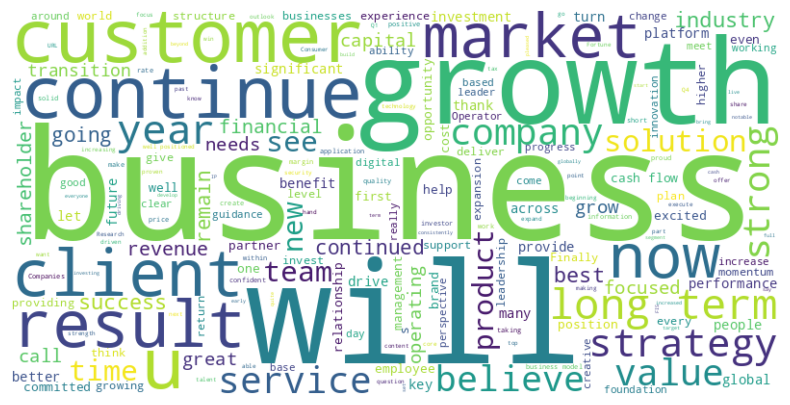

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
with open('clst5.txt','r', encoding = 'utf-8') as file:
    text = file.read()
    text = re.sub(r'[A-Z]+\.pdf','',text)
    text = re.sub(r'Executive\d','',text)
    text = re.sub(r'Company Name','',text)
    text = re.sub(r'quarter','',text)
wordcloud = WordCloud(width = 800, height = 400, background_color='white').generate(text)
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Cluster 11 appears to be capturing chunks that deal with forex situation and other international economic enviorment.

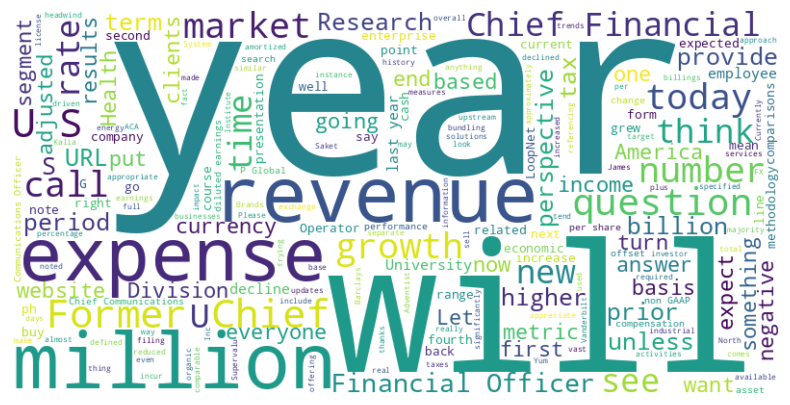

In [26]:
with open('clst11.txt','r', encoding = 'utf-8') as file:
    text = file.read()
    text = re.sub(r'[A-Z]+\.pdf','',text)
    text = re.sub(r'Executive\d','',text)
    text = re.sub(r'Company Name','',text)
    text = re.sub(r'quarter','',text)
wordcloud = WordCloud(width = 800, height = 400, background_color='white').generate(text)
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Named Entity Swapping

Now, we move on to swapping of named entities in text chunks. Again, we create a pipeline 

In [27]:
from namedEntitySwap import getEntlists
from functools import reduce

@curry
def reduce_func(func, iterable):
    return reduce(func, iterable)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [28]:
ge = getEntlists(model, index, inv_map, ['PERSON','ORG','GPE','PRODUCT','LOC','EVENT'],
            ['SG&A','FX','P&L','MG&A','CapEx','PLS','SEC','Q&A','OpEx','DSO','FY','ForEx','FAS/CAS','OCI','EUR','OI','EBITDA'])

In [29]:
ner_categories = ['PERSON','ORG','GPE','EVENT','PRODUCT']
df = pipe(range(num_cluster),map_func(ge),reduce_func(lambda x,y: x+y),pd.DataFrame).apply(lambda x: pd.Series(x[0:]).\
             drop_duplicates(), axis = 1).\
             replace({np.nan:None}).\
             apply(lambda x: pd.concat([pd.Series(x[0:3]),
                                        pd.Series(['&'.join(np.sort([ent[0] for ent in x[3:] if (ent!=None) and (ent[1]==cat)]))\
                                       for cat in ner_categories])],axis = 0), axis = 1)
df.columns = ['Key','File Name','Clst_idx','Person','Organization', 'Location','Event','Product']     

In [ ]:
#import importlib
#import namedEntitySwap
#importlib.reload(namedEntitySwap)
#from namedEntitySwap import fitEwensPitman,if_trueswap

In [30]:
from namedEntitySwap import fitEwensPitman
from itertools import combinations, product
from namedEntitySwap import swapOnce, riskMeasure

In [ ]:
iter_idx = 0
swapvars = list(('Product','Organization'))
df_swap = df
risk_measure = 1
N = 1e10
n = Y.shape[0]
theta, alpha = fitEwensPitman(df[swapvars])
while iter_idx<30:   
    retval = swapOnce(df_swap,swapvars)
    if retval == None:
        break
    df_swap,swapidx = retval
    idx1_new, idx2_new = swapidx
    idx1_s = (df[list(swapvars)] == df[df.index == idx1_new][list(swapvars)].iloc[0]).apply(lambda x: all(x),axis = 1).sum()
    idx2_s = (df[list(swapvars)] == df[df.index == idx2_new][list(swapvars)].iloc[0]).apply(lambda x: all(x),axis = 1).sum()
    numsingleton = np.sum(np.array([idx1_s,idx2_s])==1)   
    freqs = df[list(swapvars)].\
                    apply(lambda x: set(x),axis = 1).value_counts().value_counts().sort_index()
    try:
        s1 = freqs[freqs.index == 1].iloc[0]
    except IndexError:
        s1 = 0
    risk_measure = riskMeasure(risk_measure, numsingleton, N, n, s1, theta, alpha)
    print(risk_measure)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

-inf


/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:127: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pair_idx = true_swaps[true_swaps.index == clst_idx].iloc[0][-int(np.cumsum(true_swap_distri)[np.cumsum(true_swap_distri).index == clst_idx]-swap_idx)]
/home/wucloud/Documents/Anonymized-RAG/namedEntitySwap.py:134: RuntimeWarning: overflow encountered in exp
  np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

In [ ]:
riskMeasure(risk_measure, numsingleton, N, n, s1, theta, alpha)

In [ ]:
N,n,s1,theta,alpha

In [ ]:
np.exp(scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha))

In [ ]:
(n/s1*\
    np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))

In [ ]:
(n/s1*(N**(alpha-1))*\
    np.exp(scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))

In [ ]:
(alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)

In [ ]:
1-  numsingleton/s1*pprop

In [ ]:
(n/s1*(N**(alpha-1))*\
    np.exp(scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))


In [ ]:
numsingleton/s1

In [ ]:
def riskMeasure(risk_measure,numsingleton, N, n, s1, alpha, theta):
    print(np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
    pprop =(n/s1*\
    np.exp((alpha-1)*np.log(N)+scipy.special.loggamma(theta+1)-scipy.special.loggamma(theta+alpha)))
    risk_measure = risk_measure-(numsingleton/s1*pprop)
    return risk_measure

In [ ]:
N**(alpha-1)